## 1. Consultas sobre redis (local)

In [24]:
# Conexion a redis 
import redis 
from redis.sentinel import Sentinel
from typing import Tuple, Any

# Lista de Sentinels
SENTINELS = [
    ('localhost', 26379),
    ('localhost', 26380),
    ('localhost', 26381)
]

# Creamos el objeto sentiels y vemos quien es el maestro 
GROUP_NAME = 'mymaster'  
sentinel = Sentinel(SENTINELS, socket_timeout=0.5, retry_on_timeout=True)
ip_network, port_network = sentinel.discover_master(GROUP_NAME)

'''
Diccionario de traduccion de ip de la subred.
Uso:
    - traduccion[ip_subred] = puerto_correspondiente
'''
traduccion = {
    "redis-master": 6379,
    "redis-replica1": 6380,
    "redis-replica2": 6381,
    "redis-replica3": 6382,
    "172.25.0.10": 6379,
    "172.25.0.11": 6380,
    "172.25.0.12": 6381,
    "172.25.0.13": 6382
}

traduccion_2 = {
    "172.25.0.10": "redis-master",
    "redis-master": "redis-master",
    "172.25.0.11": "replica-1",
    "172.25.0.12": "replica-2",
    "172.25.0.13": "replica-3"
}

MASTER_PORT = traduccion[ip_network]

r = redis.Redis(host='localhost',
                port=MASTER_PORT,
                decode_responses=True)

print(f"Contenedor actual actuando como master: {traduccion_2[ip_network]}")

Contenedor actual actuando como master: replica-3


In [3]:
# Para comprobar cuanta memoria usada, habria que utilizarla tanto por maestro como replicas  
from typing import Dict, Any

mem: Dict[str, Any] = r.info("memory") #type: ignore
used_mb = mem["used_memory"] / 1024 / 1024
total_mb = mem.get("total_system_memory", 0) / 1024 / 1024

print(f"Usada: {used_mb:.2f} MB")
print(f"Total sistema: {total_mb:.2f} MB")

Usada: 1.31 MB
Total sistema: 7567.27 MB


### 1.1 Colas de pacientes

Se guardan listas con prioridad de pacientes para atenderlos.

In [4]:
# Scan de las colas de pacientes
zsets = r.scan(match="ED-*:DEP-*", #type: ignore
       _type="ZSET")[1]
for key in zsets:
       print(key)

ED-3:DEP-CARDIOLOGIA
ED-3:DEP-TRAUMATOLOGIA
ED-0:DEP-PEDIATRIA
ED-5:DEP-CARDIOLOGIA


In [18]:
# Comprobar el contenido de las colas añadidas:
for key in zsets:
    print(f"Contenido de: {key}")
    scan_results = r.zscan(key,match="*")
    print(f"  Database --> {scan_results[0]}",end="\n    ") #type: ignore
    for patient in scan_results[1]: #type: ignore
        print(patient, end=" ")
    print("\n")

Contenido de: ED-5:DEP-PEDIATRIA
  Database --> 0
    ('Mariana', 5.0) ('Martina', 14.0) ('Valentina', 21.0) ('Andrés', 35.0) ('Mateo', 40.0) ('Daniel', 89.0) ('Sofía', 92.0) ('Alejandro', 97.0) 

Contenido de: ED-3:DEP-OFTALMOLOGIA
  Database --> 0
    ('Sofía', 4.0) ('Alejandro', 6.0) ('Camila', 24.0) ('Diego', 24.0) ('Javier', 34.0) ('Lucía', 43.0) ('Mateo', 45.0) ('Andrés', 100.0) 

Contenido de: ED-4:DEP-NEUROLOGIA
  Database --> 0
    ('Andrés', 36.0) ('Isabella', 56.0) ('Camila', 63.0) ('Alejandro', 73.0) ('Diego', 78.0) ('Martina', 91.0) ('Lucas', 94.0) ('Sebastián', 97.0) 

Contenido de: ED-2:DEP-NEUROLOGIA
  Database --> 0
    ('Diego', 16.0) ('Lucas', 21.0) ('Mateo', 24.0) ('Alejandro', 26.0) ('Javier', 46.0) ('Isabella', 54.0) ('Daniel', 67.0) ('Valentina', 89.0) 

Contenido de: ED-0:DEP-OFTALMOLOGIA
  Database --> 0
    ('Sofía', 22.0) ('Camila', 28.0) ('Diego', 35.0) ('Sebastián', 59.0) ('Andrés', 67.0) ('Javier', 78.0) ('Mariana', 80.0) ('Valentina', 80.0) 



In [19]:
# Pacientes prioritarios en cada cola 
for key in zsets: 
    print(key)
    [(patient, score)] = r.zrevrange(key, start=0, end=0, withscores=True) #type: ignore
    print(f"-> Paciente: {patient} | Prioridad: {score}")

ED-5:DEP-PEDIATRIA
-> Paciente: Alejandro | Prioridad: 97.0
ED-3:DEP-OFTALMOLOGIA
-> Paciente: Andrés | Prioridad: 100.0
ED-4:DEP-NEUROLOGIA
-> Paciente: Sebastián | Prioridad: 97.0
ED-2:DEP-NEUROLOGIA
-> Paciente: Valentina | Prioridad: 89.0
ED-0:DEP-OFTALMOLOGIA
-> Paciente: Valentina | Prioridad: 80.0


### 1.2 Alertas de salas

En las salas habra una dinamica pub/sub para que cuando suceda algo de relevancia en la sala (generalmente relacionado con problemas) se notifique instantaneamente.

Por la tematica pub/sub, la ingesta es dinamica, por lo que se incluira directamente aqui en el notebook. La idea es que se lanzara un hilo que publique alertas mientras el hilo principal se queda a la escucha. 

**NOTA**: Para detener la ejecicion, pulsar el boton de detener celda (en mi vscode se encuentra en la esquiza superior izquierda mientras tengas la celda seleccionada).

In [ ]:
# Seleccionamos la db 1
r.select(1)

In [5]:
import threading
import time
import random
from typing import List

# Numeros de salas 
salas = [random.randint(0,20) for i in range(8)]

# Numeros de edificios 
edificios = [random.randint(0,5) for i in range(8)]

# Canales
# Formato de clave: ALERTAS:EDIFICIO:SALA
canales = list(zip(edificios, salas))
canales = [f"ALERTAS:ED-{edificio}:SALA-{sala}" for (edificio, sala) in canales]

# Funcion de ejemplo de publisher    
def publisher(canales: List[str]):

    factores = ["Temperatura", "Frecuencia cardiaca", "Glucosa en sangre",
                        "Frecuencia respiratoria", "Diuresis", "Nivel de conciencia"]

    posibles_alertas = ["Alta", "Baja"]

    # Vamos a meter 2 alertas por canal
    for canal in canales:
        for i in range(2):
            alerta = f"{factores[random.randint(0, len(factores))-1]}: {posibles_alertas[random.randint(0, len(posibles_alertas)-1)]}"
            r.publish(canal, alerta)
            time.sleep(0.5)
    print("[PUB] Todas las alertas enviadas!")

# Hilo principal: Subscriber
try:
    # Creamos el objeto tipo pub sub
    sub = r.pubsub()
    # Nos suscribimos a todos los canales
    for canal in canales:
        sub.subscribe(canal)
        
    # Creamos el hilo del publisher
    pub_thread = threading.Thread(target=publisher, args=([canales]))
    pub_thread.start()
    
    # Ponemos al hilo principal a escuchar 
    for msg in sub.listen():
        if msg['type'] == "message":
            print(f"[SUB] {msg["channel"]}: '{msg["data"]}'")
except KeyboardInterrupt: # 
    print("Subscriber terminado.")


[SUB] ALERTAS:ED-0:SALA-4: 'Frecuencia cardiaca: Baja'
[SUB] ALERTAS:ED-0:SALA-4: 'Diuresis: Baja'
[SUB] ALERTAS:ED-3:SALA-12: 'Frecuencia cardiaca: Alta'
[SUB] ALERTAS:ED-3:SALA-12: 'Frecuencia respiratoria: Alta'
[SUB] ALERTAS:ED-5:SALA-16: 'Nivel de conciencia: Baja'
[SUB] ALERTAS:ED-5:SALA-16: 'Frecuencia cardiaca: Baja'
[SUB] ALERTAS:ED-3:SALA-3: 'Glucosa en sangre: Baja'
[SUB] ALERTAS:ED-3:SALA-3: 'Diuresis: Alta'
[SUB] ALERTAS:ED-3:SALA-6: 'Nivel de conciencia: Baja'
[SUB] ALERTAS:ED-3:SALA-6: 'Diuresis: Baja'
Subscriber terminado.


[PUB] Todas las alertas enviadas!


### 1.3 Datos empleados

In [44]:
# Seleccionamos la db 2 
r.select(2)

True

In [45]:
# Buscamos las claves de nuestros empleados
print("\nClaves de empleados encontradas:")

# Sacamos los empleados
keys_empleados = r.scan(match="*")[1]#type:ignore
keys_empleados


Claves de empleados encontradas:


['empleado:1237', 'empleado:1235', 'empleado:1234', 'empleado:1236']

In [46]:
import json
import random

# Veamos el primer empleado
key_empleado = "empleado:1234"

# Usamos .json().get() para traer el objeto completo
# Es el equivalente a JSON.GET hospital:madrid:empleado:1234 $
empleado = r.json().get(key_empleado)

print(f"Datos del empleado {key_empleado}:")
# Usamos json.dumps para mostrarlo formateado
print(json.dumps(empleado, indent=2, ensure_ascii=False))

Datos del empleado empleado:1234:
{
  "nombre": "Dra. Elena Torres",
  "edad": 45,
  "sexo": "Femenino",
  "puesto": "Cirujana Jefa",
  "salario": 85000,
  "departamento": "Cirugía",
  "sala_asignada": "Quirófano 1"
}


In [47]:
key_empleado_2 = "empleado:1236"

# Para obtener solo el puesto, usamos la ruta '$.puesto'
# El $ es la raíz, el .puesto accede al campo
puesto = r.json().get(key_empleado, "$.puesto")
print(f"Puesto del empleado 1234: {puesto[0]}") # Accedemos al primer elemento [0] #type:ignore

# Podemos pedir múltiples campos
datos_cardiologo = r.json().get(key_empleado_2, "$.nombre", "$.departamento", "$.salario")
print(f"Datos del cardiólogo (1236): {datos_cardiologo}")

Puesto del empleado 1234: Cirujana Jefa
Datos del cardiólogo (1236): {'$.salario': [78000], '$.nombre': ['Dr. Miguel López'], '$.departamento': ['Cardiología']}


In [48]:
key_enfermero = "empleado:1235"

# 0. Comprobamos los datos originales del empleado 1235
print(json.dumps(r.json().get(key_enfermero, "$.nombre", "$.salario", "$.sala_asignada"), indent=2, ensure_ascii=False))

# 1. Le damos un aumento al enfermero Carlos Ruiz
# Usamos JSON.NUMINCRBY para sumar 2500 a su salario [cite: 2140]
print(f"Aumentando salario del empleado 1235...")
r.json().numincrby(key_enfermero, "$.salario", 2500)

# 2. Le cambiamos de sala
# Usamos JSON.SET para actualizar un campo existente [cite: 2133]
print(f"Cambiando de sala al empleado 1235...")
r.json().set(key_enfermero, "$.sala_asignada", "UCI Planta 5 - Box 3")

# 3. Verificamos los cambios
print("\n--- Datos actualizados del empleado 1235 ---")
datos_actualizados = r.json().get(key_enfermero, "$.nombre", "$.salario", "$.sala_asignada")
print(json.dumps(datos_actualizados, indent=2, ensure_ascii=False))

{
  "$.sala_asignada": [
    "UCI Planta 4"
  ],
  "$.nombre": [
    "Enfermero Carlos Ruiz"
  ],
  "$.salario": [
    42000
  ]
}
Aumentando salario del empleado 1235...
Cambiando de sala al empleado 1235...

--- Datos actualizados del empleado 1235 ---
{
  "$.sala_asignada": [
    "UCI Planta 5 - Box 3"
  ],
  "$.nombre": [
    "Enfermero Carlos Ruiz"
  ],
  "$.salario": [
    44500
  ]
}


## 2. Consultas sobre redis cloud 

In [2]:
# Conexion a redis cloud 
import tomli
import redis 
from redis.sentinel import Sentinel

# Cargamos el usuario y contraseña
with open("./cloud/access.toml", "rb") as f:
    access_dict = tomli.load(f)
user = access_dict["user"]
password = access_dict["pass"]

r = redis.Redis(
    host='redis-18235.c339.eu-west-3-1.ec2.cloud.redislabs.com',
    port=18235,
    decode_responses=True,
    username=user,
    password=password,
)

### 2.1 Datos geograficos de hospitales

Se guardaran los datos geograficos de hospitales utilizando el tipo "GEO" (un tipo especial de sorted set cuyo valor de ordenacion es un geohash, un hash que comprime la informacion de las coordenadas del hospital).

In [ ]:
# Primero realicemos un scan para comprobar la clave
r.scan(match="h*", _type="ZSET") # Nota: recordad que el tipo GEO es en realidad por debajo un zset cuyo valor de ordenacion es un geohash

(0, ['hospitales'])

In [ ]:
# Vamos a comprobar las localizaciones
hospitales = r.zrange("hospitales", 0, -1)
posiciones = r.geopos("hospitales", *hospitales) #type:ignore

for idx in range(len(hospitales)): # type:ignore
    print(f"{hospitales[idx]}: {posiciones[idx]}") #type:ignore

Centro Medico Aurora: (-3.75469833612442, 40.38460075651914)
Clinica del Sol Naciente: (-3.7038007378578186, 40.416799319406216)
Sanatorio Nido de Paz: (-3.630002439022064, 40.370500102709734)
Hospital General Fenix: (-3.6670008301734924, 40.43000014720406)
Hospital Sierra Vista: (-3.619000017642975, 40.485099915765765)


In [28]:
# Vamos a buscar el hospital mas cercano a nuestra localizacion
# Localizacion de ejemplo: Puerta del sol 
coords = (-3.7035285, 40.4169473)

# Hospital mas cercano a como mucho 50 km de distancia
result = r.geosearch(
    "hospitales",
    longitude=coords[0],
    latitude=coords[1],
    radius=50,
    unit="km", 
    sort="ASC", # Importante: ASC se refiere de menor distancia a mayor distancia, es contra intuitivo
    count=1,
    withdist=True
)
print(f"Hospital mas cercano: {result[0][0]}\nDistancia: {result[0][1]}") #type:ignore

Hospital mas cercano: Clinica del Sol Naciente
Distancia: 0.0283


In [40]:
# Vamos a calcular la distancia media entre hospitales
M = [[None for i in range(len(hospitales))] for i in range(len(hospitales))] #type:ignore

# Matriz de adyacencia cuyos pesos son las distancias
distancia_media = 0
for i in range(len(hospitales)): #type:ignore
    for j in range(len(hospitales)): #type:ignore
        M[i][j] = r.geodist("hospitales", #type:ignore
                            place1=hospitales[i], #type:ignore
                            place2=hospitales[j], #type:ignore
                            unit="km")
        distancia_media += M[i][j] #type:ignore
distancia_media /= len(hospitales) # type:ignore
print(f"La distancia media entre hospitales en km es: {distancia_media:.2f}km")

La distancia media entre hospitales en km es: 36.30km


He puesto adrede sol ya que la Clinica del Sol Naciente se encontraba justo en puerta del sol, y efectivamente nos la devuelve.

### 2.2 Beneficios netos a lo largo de 2024

Se guardara como una serie temporal los beneficios por mes de 2024.

In [ ]:
# Hacemos el scan de series temporales
scan_results = r.scan(match="*",
       _type="TSDB-TYPE")
scan_results[1] #type:ignore

['beneficios_2022', 'beneficios_2024', 'beneficios_2023']

In [26]:
valores_series = []
t_series = []
series = scan_results[1]#type:ignore
# Formato: valores de la serie X = valores_series[X-1]
for st in series: 
    M = r.ts().range(st, 0, "+")
    valores, t = [], []
    for i in range(len(M)):
        valores.append(M[i][0])
        t.append(M[i][1])
    valores_series.append(valores)
    t_series.append(t)

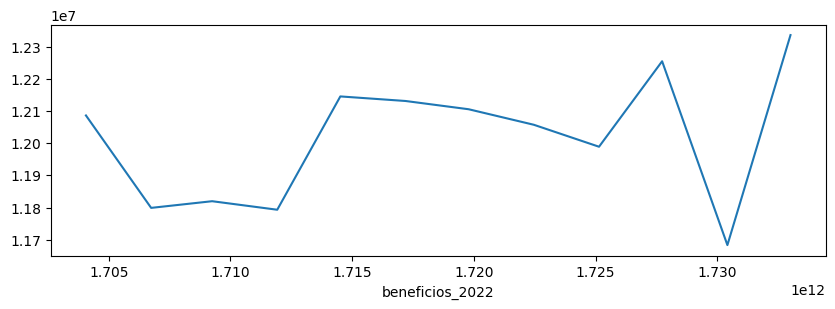

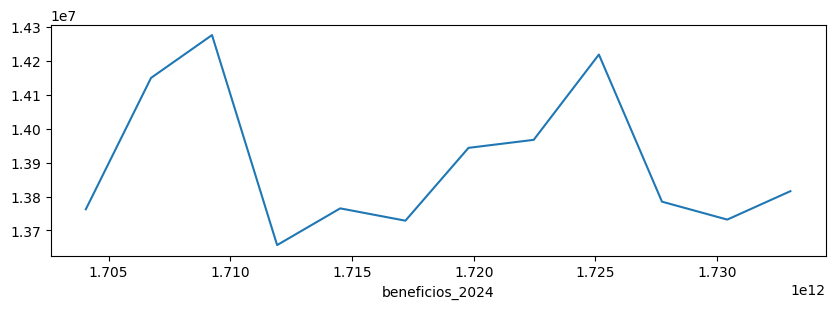

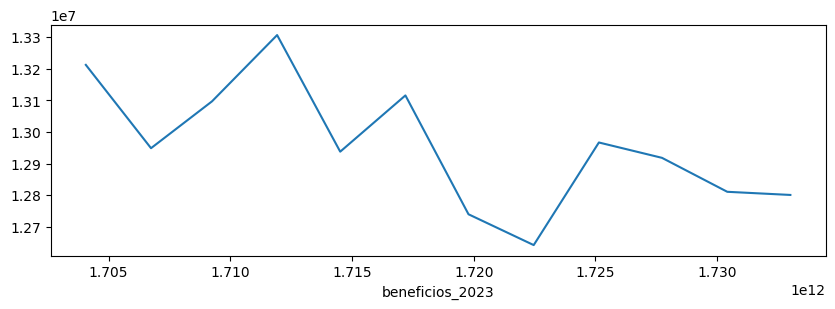

In [45]:
# Visualizarlas 
import matplotlib.pyplot as plt
for i in range(3):
    plt.figure(figsize=(10, 3))
    plt.plot(valores_series[i], t_series[i])
    plt.xlabel(series[i])
    plt.show()

### 2.3 Datos de hospitales

Se guardan como hash tables. Cada clave se asocia al nombre del hospital, su localizacion y el numero de salas de cada tipo de especializacion.

In [ ]:
# Sacamos las claves
keys = r.scan(match="datos*")[1]#type:ignore
keys

['datos_hosp_0',
 'datos_hosp_1',
 'datos_hosp_3',
 'datos_hosp_2',
 'datos_hosp_4']

In [ ]:
# Todas las claves
r.hkeys(keys[0]) # En este caso todos tienen las mismas, pero no tendria por que.

['nombre',
 'localizacion',
 'cardiologia',
 'oftalmologia',
 'pediatria',
 'ginecologia',
 'urologia',
 'traumatologia',
 'reumatologia',
 'oncologia']

In [ ]:
# Veamos una de ejemplo:
print(f"El hospital '{r.hget(name="datos_hosp_0", key="nombre")}' tiene:"
      f"\n- {r.hget(name="datos_hosp_0", key="oncologia")} salas de oncologia"
      f"\n- {r.hget(name="datos_hosp_0", key="oftalmologia")} salas de oftalmologia",
      f"\n- {r.hget(name="datos_hosp_0", key="cardiologia")} salas de cardiologia")

El hospital 'Clinica del Sol Naciente' tiene:
- 2 salas de oncologia
- 9 salas de oftalmologia 
- 3 salas de cardiologia


In [17]:
# Recuperar todos los campos
r.hgetall(keys[1])

{'nombre': 'Hospital Sierra Vista',
 'localizacion': 'Barrio de Fuencarral',
 'cardiologia': '10',
 'oftalmologia': '2',
 'pediatria': '10',
 'ginecologia': '7',
 'urologia': '2',
 'traumatologia': '2',
 'reumatologia': '10',
 'oncologia': '9'}